### Thesis notebook 4.2. - R_Gonz

### Aplication of SMOTE - Keeping Outliers

### Non-temporal data representation

In [1]:
#import necessary modules/libraries
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import warnings
import time
import plotly.express as px

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

from lightgbm import LGBMModel,LGBMClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer,PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_classif, RFE, RFECV, SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import AgglomerativeClustering , KMeans, DBSCAN

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.datasets import make_classification, load_digits
from sklearn import svm
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, recall_score, classification_report, average_precision_score, precision_recall_curve

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col
    
#number of replicas - number of repeats of stratified k fold - in this case 10
replicas = 10

In [3]:
#imports dataframes
course_programs = pd.read_excel("../Data/Modeling Stage/R_gonz_Non_temporal_Datasets.xlsx", 
                                dtype = {
                                    'course' : object,
                                    'userid' : object},
                               sheet_name = None)

#drop unnamed 0 column
for i in course_programs:
    course_programs[i].drop('Unnamed: 0', axis = 1, inplace = True)
    
#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/R_Gonz_updated_classlist.csv', 
                         dtype = {
                                   'course': object,
                                   },
                        parse_dates = ['Week before start', 'Start Date',
                                       'End Date', 'Date_threshold_10',
                                      'Date_threshold_25', 'Date_threshold_33', 'Date_threshold_50',
                                      'Date_threshold_100']).drop('Unnamed: 0', axis = 1)

In [4]:
course_programs['Date_threshold_10'].describe()

,Number of clicks,Number of sessions,Clicks on campus,Largest period of inactivity (h),Total time online (min),Average session duration (min),Start of Session 1 (%),Start of Session 2 (%),Start of Session 3 (%),Start of Session 4 (%),...,On/off campus click ratio,Number of days,Clicks per day,Clicks per session,Clicks (% of course total),Submissions (% of course total),Days with no interaction (%),final_mark,Average grade of assignments,Links viewed
count,21622.000000,21622.000000,21622.000000,21622.000000,21622.000000,21622.000000,21622.000000,18087.000000,14811.000000,12054.000000,...,21622.000000,21622.000000,21622.000000,21622.000000,21622.000000,3637.000000,21622.000000,25975.000000,3676.000000,3536.000000
mean,32.155074,5.830312,25.308020,5772.432707,38.957110,6.343694,2.713460,4.067352,4.957966,5.582741,...,23.418602,23.302285,1.499175,5.624281,0.015910,0.027770,46.793977,4.659479,0.451106,3.270079
std,41.541887,5.881499,35.797054,4851.695269,63.143689,8.639087,5.859286,5.715840,5.540221,5.328757,...,34.938335,5.306752,2.072179,5.294475,0.020598,0.068122,19.838522,3.099980,0.416523,5.083380
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-21.875000,-21.875000,-21.875000,-21.875000,...,0.000000,11.000000,0.025641,1.000000,0.000060,0.000953,0.000000,0.000000,0.000000,1.000000
25%,8.000000,2.000000,4.000000,1725.750000,2.833333,0.966667,0.813008,1.626016,2.439024,3.041825,...,2.000000,18.000000,0.343750,2.857143,0.004425,0.010204,33.333332,2.128713,0.000000,1.000000
50%,20.000000,4.000000,14.000000,5457.000000,15.300000,3.515278,3.515625,5.109489,5.839416,6.504065,...,12.000000,25.000000,0.840000,4.363636,0.010118,0.015504,46.875000,4.572391,0.490278,2.000000
75%,40.000000,8.000000,33.000000,8606.000000,49.566667,8.515833,6.329114,7.692308,8.759124,9.489051,...,30.000000,25.000000,1.833333,6.750000,0.019892,0.027027,60.000000,7.328528,0.875000,3.000000
max,1122.000000,125.000000,700.000000,40434.000000,1739.833333,127.216667,16.981132,18.867925,18.867925,18.867925,...,700.000000,39.000000,62.333332,156.000000,0.615385,1.000000,96.000000,10.000000,1.000000,112.000000


##  Stage: Data understanding Stage

#### INITIAL EXPLORATION, CLEANING & FEATURE ENGINEERING

In [5]:
#Step1 - Take a look at the datesets
for i in course_programs:
    print(f'Time period: {i}\n\n{course_programs[i].head()}\n')

Time period: Date_threshold_10

   course   userid  Number of clicks  Number of sessions  Clicks on campus  \
0  1010.0  14685.0               NaN                 NaN               NaN   
1  1010.0  15403.0               NaN                 NaN               NaN   
2  1010.0  15592.0               NaN                 NaN               NaN   
3  1010.0  16457.0               NaN                 NaN               NaN   
4  1010.0  17576.0               NaN                 NaN               NaN   

   Largest period of inactivity (h)  Total time online (min)  \
0                               NaN                      NaN   
1                               NaN                      NaN   
2                               NaN                      NaN   
3                               NaN                      NaN   
4                               NaN                      NaN   

   Average session duration (min)  Start of Session 1 (%)  \
0                             NaN                    

In [6]:
#Step1 - Take a look at the datesets
for i in course_programs:
    print(f'Time period: {i}\n\n{course_programs[i].info()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25975 entries, 0 to 25974
Data columns (total 39 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   course                            25975 non-null  object 
 1   userid                            25975 non-null  object 
 2   Number of clicks                  21622 non-null  float64
 3   Number of sessions                21622 non-null  float64
 4   Clicks on campus                  21622 non-null  float64
 5   Largest period of inactivity (h)  21622 non-null  float64
 6   Total time online (min)           21622 non-null  float64
 7   Average session duration (min)    21622 non-null  float64
 8   Start of Session 1 (%)            21622 non-null  float64
 9   Start of Session 2 (%)            18087 non-null  float64
 10  Start of Session 3 (%)            14811 non-null  float64
 11  Start of Session 4 (%)            12054 non-null  float64
 12  Star

In [7]:
#describe method
for i in tqdm(course_programs):
    print(f'Time period: {i}\n\n{course_programs[i].describe(include = "all")}\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Time period: Date_threshold_10

        course   userid  Number of clicks  Number of sessions  \
count    25975    25975      21622.000000        21622.000000   
unique     353    12195               NaN                 NaN   
top     2271.0  55072.0               NaN                 NaN   
freq       642       10               NaN                 NaN   
mean       NaN      NaN         32.155074            5.830312   
std        NaN      NaN         41.541887            5.881499   
min        NaN      NaN          1.000000            1.000000   
25%        NaN      NaN          8.000000            2.000000   
50%        NaN      NaN         20.000000            4.000000   
75%        NaN      NaN         40.000000            8.000000   
max        NaN      NaN       1122.000000          125.000000   

        Clicks on campus  Largest period of inactivity (h)  \
count       21622.000000                      21622.000000   
unique               NaN                               NaN   
t

Time period: Date_threshold_33

        course   userid  Number of clicks  Number of sessions  \
count    25975    25975      25023.000000        25023.000000   
unique     353    12195               NaN                 NaN   
top     2271.0  55072.0               NaN                 NaN   
freq       642       10               NaN                 NaN   
mean       NaN      NaN         89.192223           16.193702   
std        NaN      NaN         98.219724           14.600225   
min        NaN      NaN          1.000000            1.000000   
25%        NaN      NaN         33.000000            7.000000   
50%        NaN      NaN         66.000000           13.000000   
75%        NaN      NaN        114.000000           21.000000   
max        NaN      NaN       5165.000000          280.000000   

        Clicks on campus  Largest period of inactivity (h)  \
count       25023.000000                      25023.000000   
unique               NaN                               NaN   
t

Time period: Date_threshold_100

        course   userid  Number of clicks  Number of sessions  \
count    25975    25975      25975.000000        25975.000000   
unique     353    12195               NaN                 NaN   
top     2271.0  55072.0               NaN                 NaN   
freq       642       10               NaN                 NaN   
mean       NaN      NaN        241.154456           44.751222   
std        NaN      NaN        274.521499           39.000865   
min        NaN      NaN          1.000000            1.000000   
25%        NaN      NaN        108.000000           20.000000   
50%        NaN      NaN        190.000000           36.000000   
75%        NaN      NaN        308.000000           58.000000   
max        NaN      NaN      21978.000000          825.000000   

        Clicks on campus  Largest period of inactivity (h)  \
count       25975.000000                      25975.000000   
unique               NaN                               NaN   


#### SOME DATA EXPLORATION

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Date_threshold_25
Date_threshold_33
Date_threshold_50
Date_threshold_100


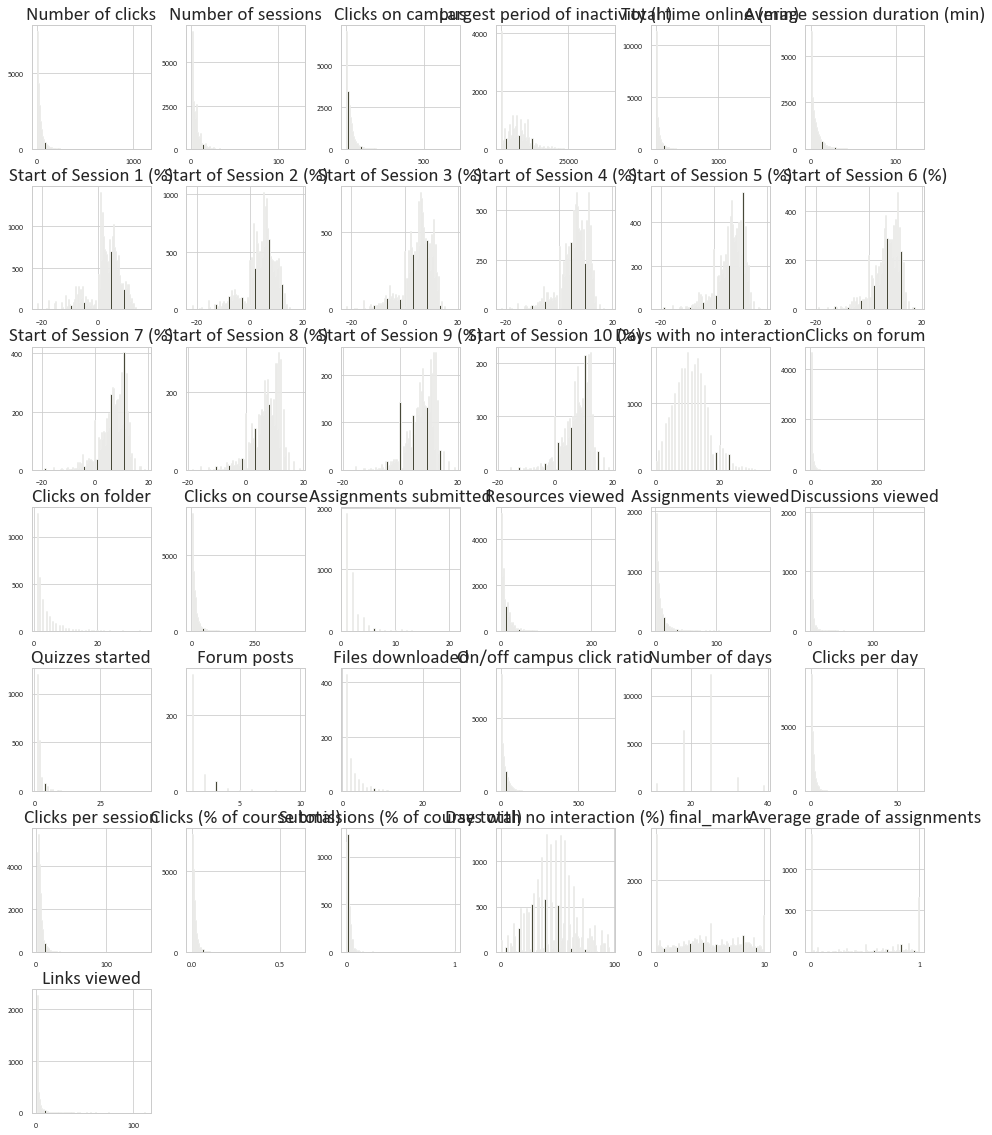

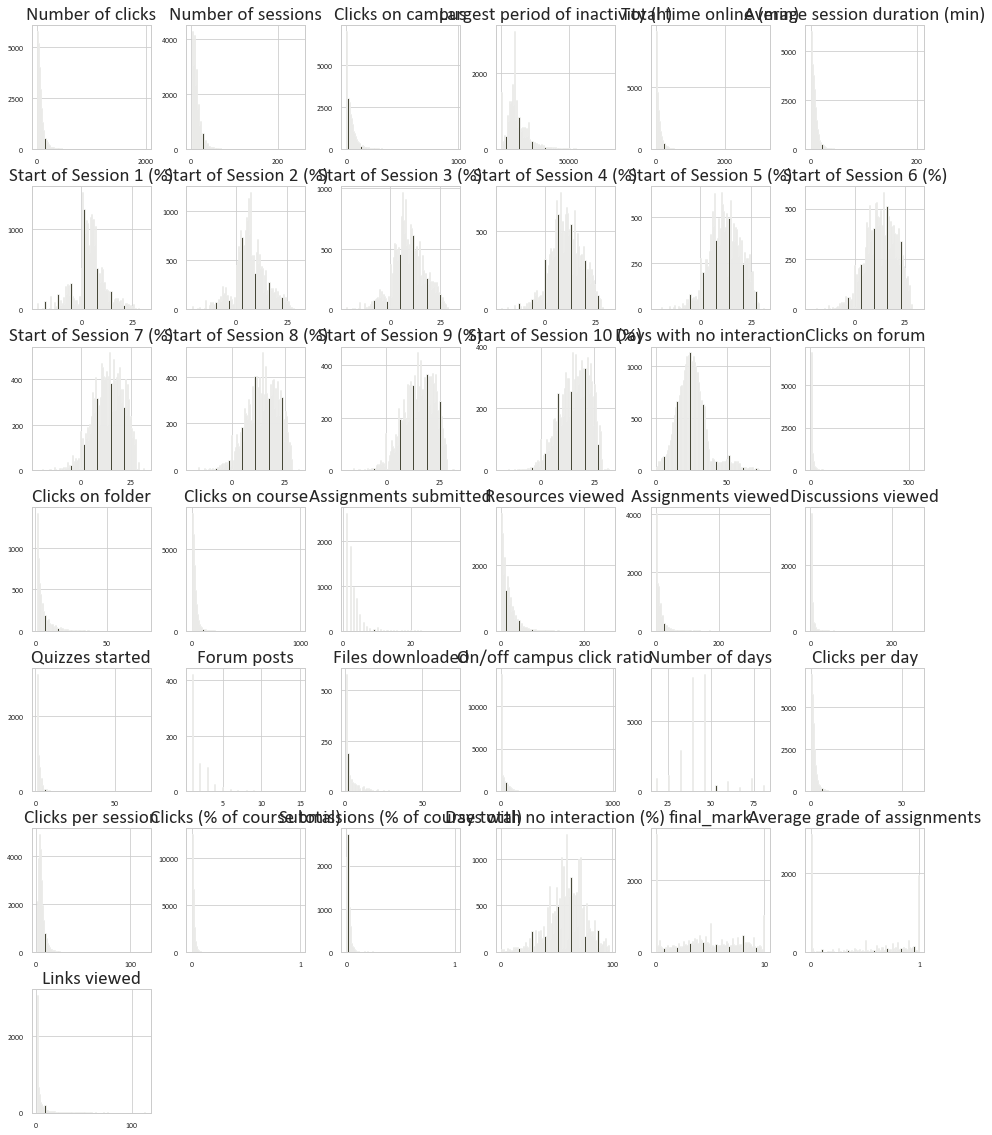

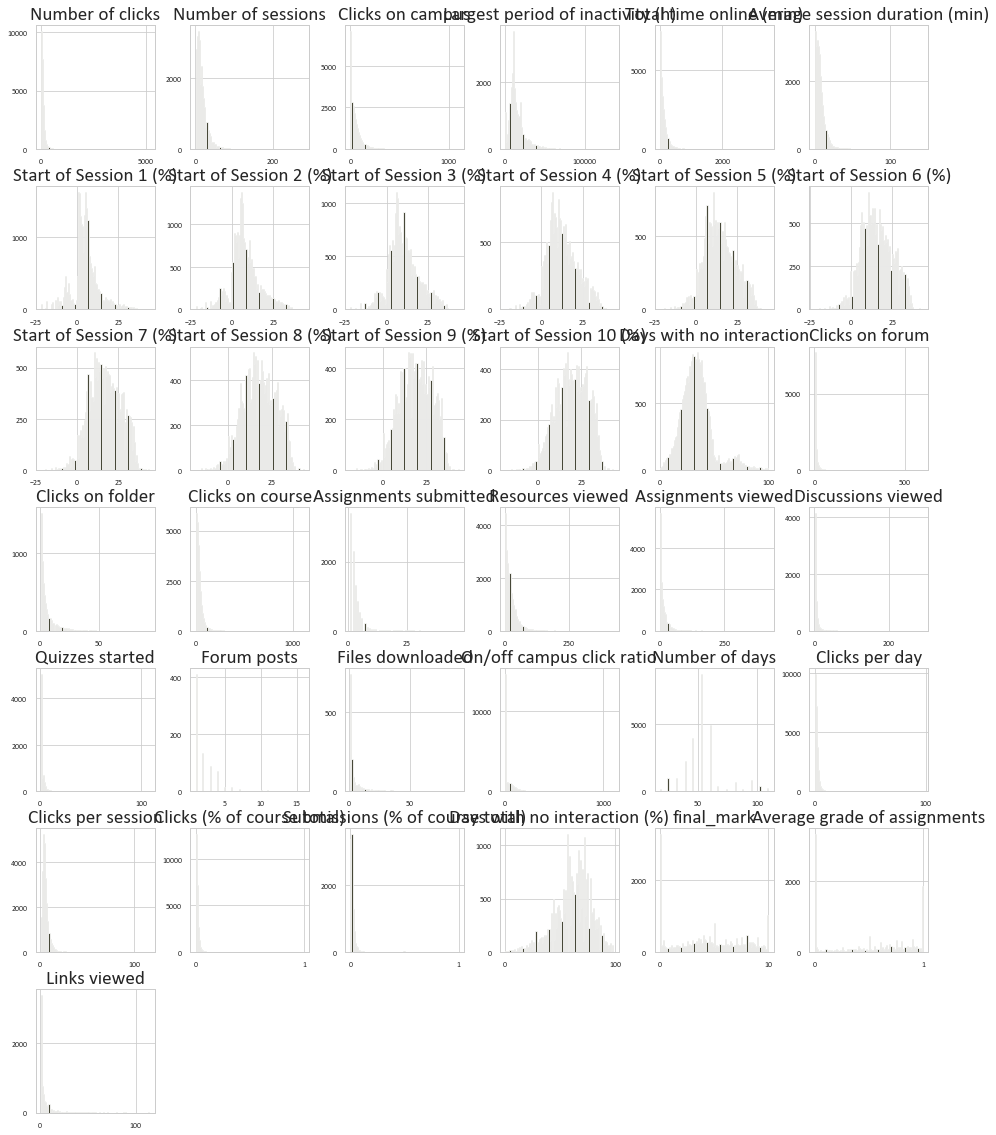

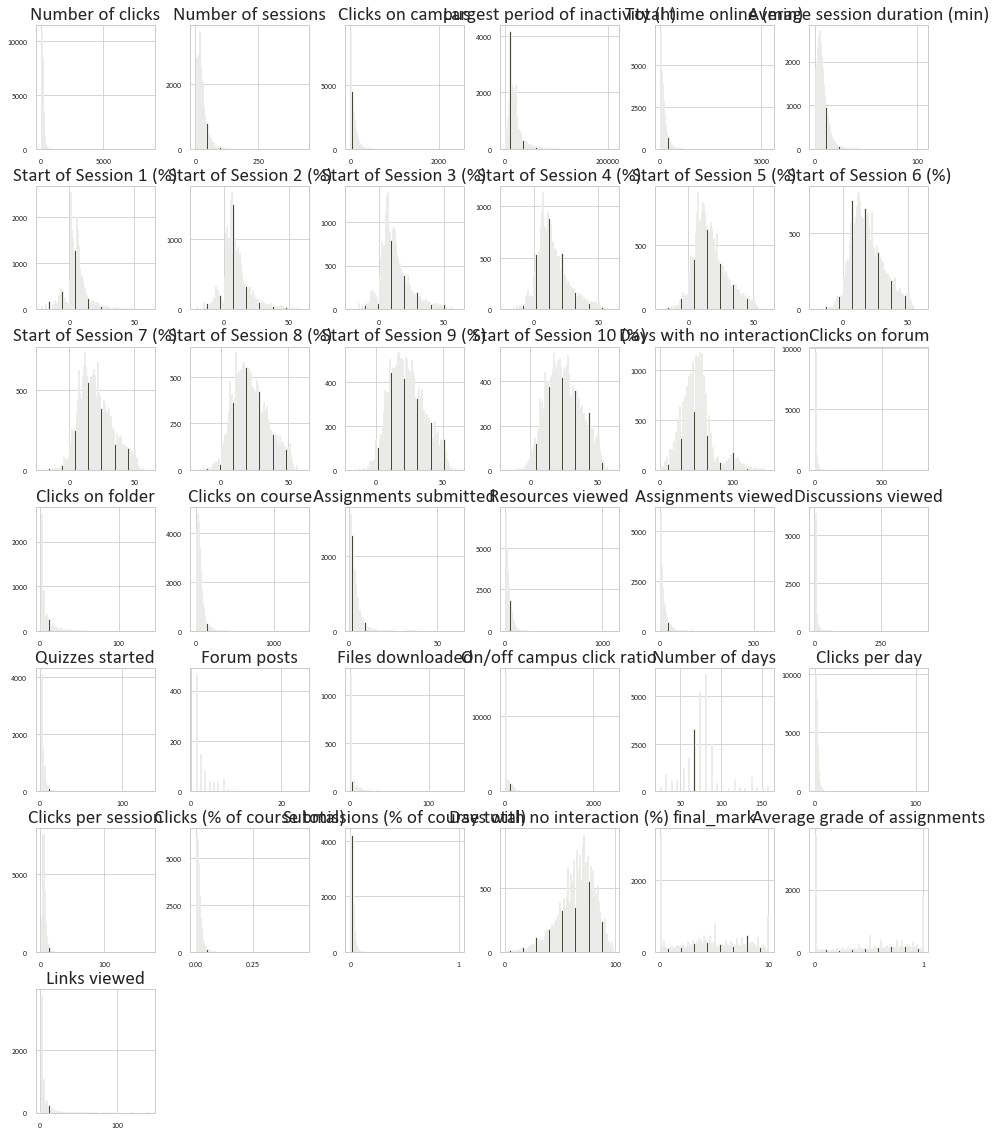

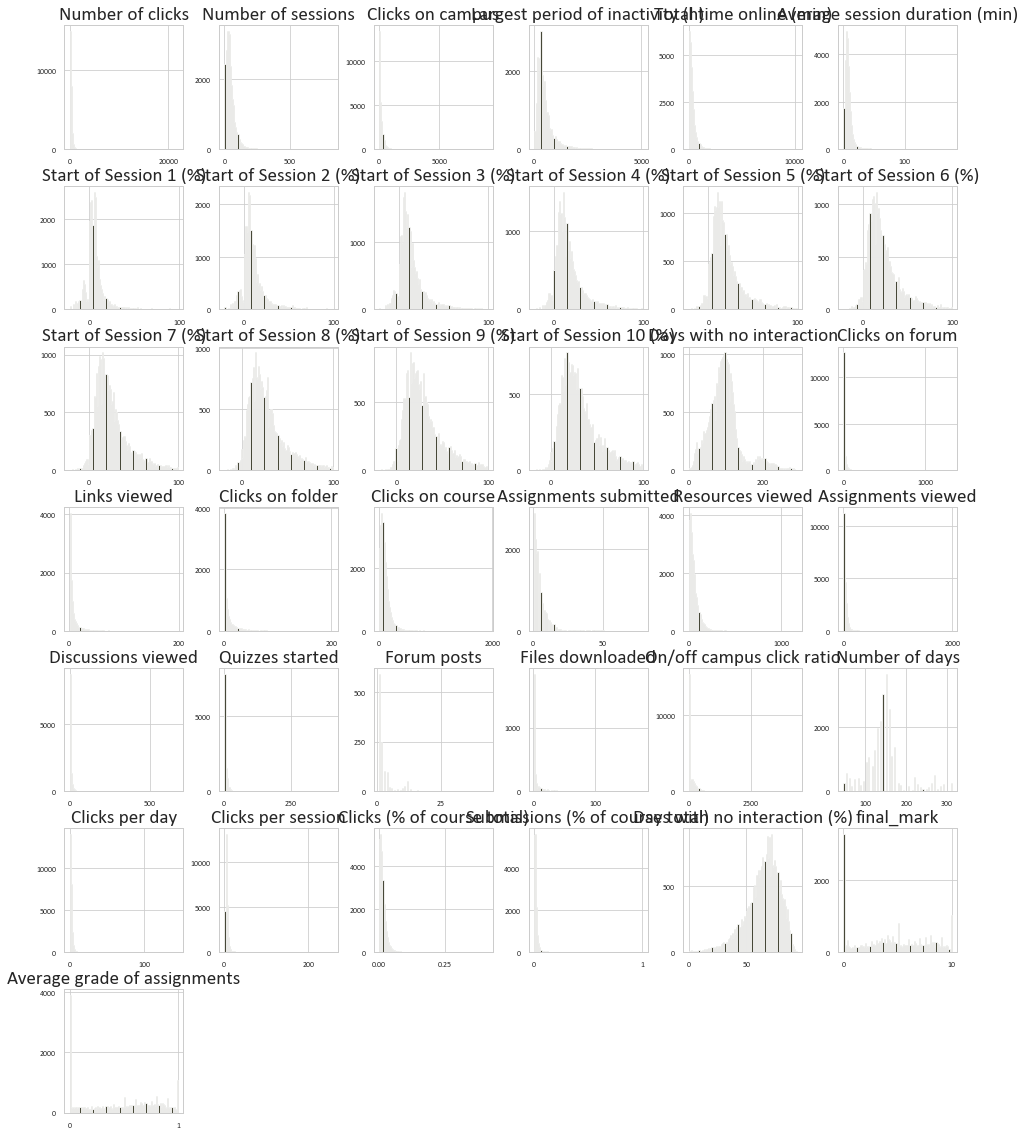

In [8]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)

#Plot the distributions of each feature 
for i in tqdm(course_programs):
    print(i)
    course_programs[i].hist(figsize=(16, 20), bins=100, xlabelsize=8, ylabelsize=8, color = student_color)

#### Converting target:

As stated, we will predict the exam grade as it does not depend direcly from assignment grades.

We will use a double classification problem:

**Problem 1**: Identify students at risk of failure. In the portuguese system, a student passes if the final grade greater or equal to 10. Students who do not meet the threshold fail. When it comes to exams, the difference is not as clear cut. For simplicity, we will consider exam grade to be less or equal to 10 - same with final grade. 

**Problem 2**: Identify high performing students. The classification of high performers is not unanymous. A simple solution would be consider as high performers all students whose grade is greater or equal to a certain threshold (say 17/20). There are issues with this approach however:

    - different teachers have different criteria for grading and their grading decisions. We can look at the top 20% of students in each course as identify them as the high performers. 

In [10]:
#create loops for targets
for i in tqdm(course_programs):
    print(i)
    
    #deal with risk of failure
    course_programs[i]['final_fail'] = np.where(course_programs[i]['final_mark'] > 5, 0, 1) #at risk in final grade   
    
    #deal with gifted classification
    course_programs[i]['final_gifted'] = np.where(course_programs[i]['final_mark'] >= 8.5, 1, 0) #gifted students according to final grade

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Date_threshold_25
Date_threshold_33
Date_threshold_50
Date_threshold_100


In [11]:
course_programs['Date_threshold_100'].describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
course,25975,353,2271.0,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userid,25975,12195,55072.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of clicks,25975.0,NaN,NaN,NaN,241.154456,274.521499,1.0,108.0,190.0,308.0,21978.0
Number of sessions,25975.0,NaN,NaN,NaN,44.751222,39.000865,1.0,20.0,36.0,58.0,825.0
Clicks on campus,25975.0,NaN,NaN,NaN,144.371049,199.979075,0.0,31.0,84.0,197.0,8977.0
Largest period of inactivity (h),25975.0,NaN,NaN,NaN,505.086244,417.581921,0.0,254.041667,381.616667,620.5,5039.283333
Total time online (min),25975.0,NaN,NaN,NaN,314.451714,340.389591,0.0,106.158333,224.866667,412.925,10202.233333
Average session duration (min),25975.0,NaN,NaN,NaN,7.544157,6.638604,0.0,3.910544,6.211574,9.335743,176.733333
Start of Session 1 (%),25975.0,NaN,NaN,NaN,6.849877,12.920404,-21.875,1.459854,4.878049,9.174312,98.393574
Start of Session 2 (%),25710.0,NaN,NaN,NaN,10.826902,14.694054,-21.875,3.157895,7.29927,13.907285,98.947368


#### Looking for Group (Course) Aggregates

We will look at the 100% duration logs in order to make most of our verification. After all, the 100% duration threshold will be the basis for comparison.

We will, for now, use the following immediate criteria for exclusion:
1. Median % of days with no interaction > 80%,
2. To have 0 mean for at-risk students or gifted students.

In [12]:
aggregates = course_programs['Date_threshold_100'].groupby('course').agg({
                                                                'userid' :  [('Number of users','nunique')],
                                                                'Number of sessions' : ['min', 'mean', 'median', 'max'],
                                                                'Clicks per day' : ['min', 'mean', 'median', 'max'],
                                                                'Days with no interaction (%)' : ['min', 'mean', 'median', 'max'], 
                                                                'final_fail' : 'mean',
                                                                'final_gifted' : 'mean',                                                                
                                                                    })
#show all
with pd.option_context("display.max_rows", None):
    display(aggregates)
    
        #same for session features
aggregates.columns = aggregates.columns.map(flattenHierarchicalCol)
aggregates.reset_index(inplace = True)

userid Number of sessions                          \
       Number of users                min        mean median  max   
course                                                              
1010.0              48                 11   51.854167   48.5  113   
1013.0              71                 15   51.422535   44.0  138   
1020.0              64                  4   71.828125   59.0  469   
1024.0              78                  1   31.730769   26.0  182   
1026.0             112                  4   33.758929   28.0  169   
1027.0              55                 14   74.072727   67.0  212   
1039.0              91                 10   86.010989   73.0  482   
1044.0              74                  7   40.675676   35.5  203   
1048.0              44                 10   66.340909   63.5  177   
1051.0              32                  5   68.906250   44.0  582   
1059.0             135                  1   37.940741   31.0  151   
1062.0              31                 28   83.967742   80.0  280   
1065.0              80                  1   57.475000   47.0  514   
1073.0             129                  7   61.565891   54.0  228   
1077.0              26                  2   39.384615   36.5  116   
1087.0              31                  1  109.258065  100.0  315   
1090.0              52                  1   45.115385   43.0  118   
1104.0              95                  2   48.378947   47.0  194   
1105.0              25                  9   36.800000   32.0  112   
1106.0              82                  9   98.548780   92.5  710   
1108.0              38                  9   34.842105   35.5   63   
1112.0             199                  1   61.969849   55.0  264   
1114.0              51                  9   83.549020   76.0  409   
1115.0              35                  6   50.514286   40.0  153   
1123.0              47                  3   49.574468   50.0  104   
1127.0              91                  7   34.978022   31.0  107   
1131.0             115                  1   39.695652   38.0  120   
1133.0              41                  5   45.024390   45.0   96   
1137.0              47                  3   50.638298   46.0  128   
1142.0              59                 17   69.508475   67.0  200   
1143.0              85                  1   57.188235   44.0  542   
1156.0              55                  3   55.509091   51.0  118   
1159.0              62                  9   54.693548   42.5  206   
1163.0              28                  3   43.464286   43.5   85   
1167.0              63                  9   59.793651   51.0  223   
1170.0              79                  9   51.556962   44.0  233   
1177.0             129                  8   33.837209   30.0  167   
1193.0              73                  8   33.602740   28.0  116   
1194.0              99                  4   53.545455   51.0  144   
1200.0             107                  2   65.607477   64.0  244   
1201.0              78                 12   55.910256   47.0  203   
1215.0              28                  1   46.678571   43.0  118   
1217.0              26                 15   59.961538   57.0  116   
1222.0              29                  1   39.551724   32.0  158   
1231.0              33                  2   53.303030   52.0  155   
1233.0              81                  1   47.395062   45.0  119   
1268.0              39                 14   80.230769   73.0  211   
1288.0              51                  2   45.901961   46.0  101   
1294.0              49                  1   31.326531   28.0  124   
1300.0              26                 14   54.423077   36.0  284   
1303.0             119                  1   31.235294   26.0  111   
1305.0              85                  3   47.882353   41.0  347   
1308.0              25                  1   75.360000   61.0  370   
1313.0             118                  5   66.449153   61.5  244   
1314.0              29                  2   18.862069   17.0   55   
1318.0        

In [13]:
#only keep rows that fulfill the criteria - median user with less than 80% days without interaction 
aggregates = aggregates[~((aggregates['Days with no interaction (%)_median'] > 85) | (aggregates['final_fail_mean'] == 0) | (aggregates['final_gifted_mean'] == 0))]
courses_to_keep = aggregates['course'].unique()

#filtering dataset for all course durations
for i in tqdm(course_programs):
    course_programs[i] = course_programs[i][course_programs[i]['course'].isin(courses_to_keep)].reset_index(drop = True)

course_programs['Date_threshold_100'].describe(include = 'all').T

  0%|          | 0/5 [00:00<?, ?it/s]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
course,13857,174,2059.0,507,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userid,13857,8544,68888.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of clicks,13857.0,NaN,NaN,NaN,228.247167,198.911148,1.0,104.0,181.0,293.0,5248.0
Number of sessions,13857.0,NaN,NaN,NaN,43.088908,37.446194,1.0,19.0,34.0,56.0,651.0
Clicks on campus,13857.0,NaN,NaN,NaN,134.819153,167.056064,0.0,32.0,78.0,180.0,3365.0
Largest period of inactivity (h),13857.0,NaN,NaN,NaN,524.804228,430.516288,0.0,261.666667,387.75,647.033333,5039.283333
Total time online (min),13857.0,NaN,NaN,NaN,307.201762,340.711267,0.0,100.966667,214.233333,398.366667,10202.233333
Average session duration (min),13857.0,NaN,NaN,NaN,7.757331,7.440116,0.0,3.842857,6.175278,9.425,176.733333
Start of Session 1 (%),13857.0,NaN,NaN,NaN,6.638458,12.684555,-21.875,1.459854,4.861111,9.090909,97.692308
Start of Session 2 (%),13749.0,NaN,NaN,NaN,10.942395,14.836541,-21.875,3.249097,7.317073,14.453125,98.540146


In [14]:
course_programs['Date_threshold_100'].columns

Index(['course', 'userid', 'Number of clicks', 'Number of sessions',
       'Clicks on campus', 'Largest period of inactivity (h)',
       'Total time online (min)', 'Average session duration (min)',
       'Start of Session 1 (%)', 'Start of Session 2 (%)',
       'Start of Session 3 (%)', 'Start of Session 4 (%)',
       'Start of Session 5 (%)', 'Start of Session 6 (%)',
       'Start of Session 7 (%)', 'Start of Session 8 (%)',
       'Start of Session 9 (%)', 'Start of Session 10 (%)',
       'Days with no interaction', 'Clicks on forum', 'Links viewed',
       'Clicks on folder', 'Clicks on course', 'Assignments submitted',
       'Resources viewed', 'Assignments viewed', 'Discussions viewed',
       'Quizzes started', 'Forum posts', 'Files downloaded',
       'On/off campus click ratio', 'Number of days', 'Clicks per day',
       'Clicks per session', 'Clicks (% of course total)',
       'Submissions (% of course total)', 'Days with no interaction (%)',
       'final_mark', 'Ave

In [22]:
# Organizar features
targets = ['final_fail', 'final_gifted']

numeric_feat = [ 'Number of clicks', 'Number of sessions',
       'Largest period of inactivity (h)', 'Total time online (min)',
       'Average session duration (min)', 'Start of Session 1 (%)',
       'Start of Session 2 (%)', 'Start of Session 3 (%)',
       'Start of Session 4 (%)', 'Start of Session 5 (%)',
       'Start of Session 6 (%)', 'Start of Session 7 (%)',
       'Start of Session 8 (%)', 'Start of Session 9 (%)',
       'Start of Session 10 (%)', 'Days with no interaction',
       'Clicks on forum', 'Links viewed', 'Clicks on folder',
       'Clicks on course', 'Resources viewed', 'Discussions viewed',
       'Quizzes started', 'Files downloaded', 'Assignments submitted',
       'Assignments viewed', 'Forum posts', 'Number of days', 'Clicks per day',
       'Clicks per session', 'Clicks (% of course total)',
       'Submissions (% of course total)', 'Days with no interaction (%)', 'Average grade of assignments',
        'On/off campus click ratio', 'Clicks on campus']

#optional features -> assignment grades
#optional_feats =[]

#binary_feat = []

#categorical_feat = []

#date = []

drop_feat = ['final_mark']

In [16]:
#Data Quality Report for Continuous Features

def DescribeContinuousFeatures(Continuous_Features, dataset):
    Continuous_Head = ['Count', 'Missing Values (%)', 'Cardinality', 'Minimum', '1st Qrt.', 'Mean', 'Median', '3rd Qrt.', 'Maximum', 'Std. Dev.']
    Continuous_Describe = pd.DataFrame(index=Continuous_Features, columns=Continuous_Head)
    Continuous_Describe.index.name = 'Feature Name'
    columns = dataset[Continuous_Features]

#Total Number of Instances
    Continuous_Describe[Continuous_Head[0]] = columns.count()

#Percentage of instances that has Missing Values (sabendo à partida que nenhuma variável contínua tem missings)
    Continuous_Describe[Continuous_Head[1]] = columns.isnull().sum() * 100 / len(dataset)
    
#Cardinality of each feature (cardinality measures the number of Distinct Values)
    Continuous_Describe[Continuous_Head[2]] = columns.nunique()

#Minimum Value
    Continuous_Describe[Continuous_Head[3]] = columns.min()

#1ST Quartile
    Continuous_Describe[Continuous_Head[4]] = columns.quantile(0.25)

#Mean
    Continuous_Describe[Continuous_Head[5]] = round(columns.mean(), 2)

#Median
    Continuous_Describe[Continuous_Head[6]] = columns.median()

#3rd Quartile
    Continuous_Describe[Continuous_Head[7]] = columns.quantile(0.75)

#Maximum Value
    Continuous_Describe[Continuous_Head[8]] = columns.max()

#Standard Deviation
    Continuous_Describe[Continuous_Head[9]] = round(columns.std(),2)
    
    return Continuous_Describe

for i in tqdm(course_programs):
    print(f'{i}\n\n{DescribeContinuousFeatures(numeric_feat,course_programs[i])}\n')

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10

                                  Count  Missing Values (%)  Cardinality  \
Feature Name                                                               
Number of clicks                  11524           16.836256          243   
Number of sessions                11524           16.836256           55   
Largest period of inactivity (h)  11524           16.836256         6605   
Total time online (min)           11524           16.836256         4734   
Average session duration (min)    11524           16.836256         6718   
Start of Session 1 (%)            11524           16.836256          479   
Start of Session 2 (%)             9581           30.858050          510   
Start of Session 3 (%)             7813           43.616945          483   
Start of Session 4 (%)             6270           54.752111          457   
Start of Session 5 (%)             5029           63.707873          428   
Start of Session 6 (%)             4067           70.650213          

Date_threshold_50

                                  Count  Missing Values (%)  Cardinality  \
Feature Name                                                               
Number of clicks                  13636            1.594862          659   
Number of sessions                13636            1.594862          160   
Largest period of inactivity (h)  13636            1.594862        10326   
Total time online (min)           13636            1.594862         9955   
Average session duration (min)    13636            1.594862        12333   
Start of Session 1 (%)            13636            1.594862         1068   
Start of Session 2 (%)            13373            3.492820         1274   
Start of Session 3 (%)            13083            5.585625         1373   
Start of Session 4 (%)            12777            7.793895         1398   
Start of Session 5 (%)            12413           10.420726         1436   
Start of Session 6 (%)            12058           12.982608         1

The cell below may be commented for faster computation.

In [17]:
# sns.set_theme(context='paper', style='whitegrid', font='Calibri', font_scale=2)

# for i in tqdm(course_programs):
    
#     print(i)
#     #perform a very simple pairplot
#     g = sns.PairGrid(course_programs[i][numeric_feat], corner = True)
    
#     #frequency histogram on diagonal
#     g.map_diag(sns.histplot, color = 'grey', stat = 'frequency', kde = True)
    
#     #regplot is a scatter with regression line
#     g.map_offdiag(sns.regplot, fit_reg=True, x_jitter=.1, color = course_color,  marker = 'x')
    
#     # Layout
#     plt.subplots_adjust(top=0.95)
#     plt.title("Pairwise Relationship of Numerical Variables", fontweight="bold")
    
#     plt.savefig(f'../Images/R_Gonz_numerical_feats_{i}_pair.png', transparent=True, dpi=300)
#     plt.close("all")

In [18]:
def cor_heatmap(cor):
    plt.figure(figsize=(32,32))
    return sns.heatmap(data = cor, annot = True, cmap = standard_cmap, fmt='.1',
                vmin = -1, vmax = 1,
               )
    
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(32, 32)}, font_scale=2)

for i in tqdm(course_programs):
    print(i)
    cor_spearman = course_programs[i][numeric_feat].corr(method = 'spearman')
    g = cor_heatmap(cor_spearman)
    fig = g.get_figure()
    fig.savefig(f'../Images/R_gonz_numerical_feats_{i}_heat.png', transparent=True, dpi=300)
    plt.close("all")
    
del g, fig

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Date_threshold_25
Date_threshold_33
Date_threshold_50
Date_threshold_100


### Immediate observations

Very low correlations throughout most metric features, eith the exception of a couple.
Still need to verify what to do concerning outliers.

## Functions to Call later

In [19]:
def feature_selection_table(dataset, target):

    feature_df = dataset.copy()
    
    X = feature_df.drop(targets,axis=1)
    y = feature_df[target]
    num_feats=len(X.columns)
    X_norm = MinMaxScaler().fit_transform(X)

    #RFE
    rfe_selector = RFE(estimator=DecisionTreeClassifier(), step=2)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()

    #RFECV
    rfecv_selector = RFECV(estimator=DecisionTreeClassifier(), step=1, cv=5, scoring='f1_weighted',
                          min_features_to_select = 10)
    rfecv_selector = rfecv_selector.fit(X_norm, y)
    rfecv_support = rfecv_selector.support_
    rfecv_feature = X.loc[:,rfecv_support].columns.tolist()

    #Logistic regression
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

    #RandomForest 
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


    #LGBMClassifier
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

    #Lasso
    reg = LassoCV(random_state=123) 
    reg.fit(X=X,y=y)
    lasso_coef = pd.Series(reg.coef_,index = X.columns)

    #Ridge
    ridge = RidgeCV()
    ridge.fit(X=X,y=y)
    coef_ridge = pd.Series(ridge.coef_,index = X.columns)

    #Elastic 
    elast = ElasticNetCV(cv=5, random_state=123)
    elast.fit(X, y)
    elast_coef = pd.Series(elast.coef_,index = X.columns)

    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature':X.columns, 'RFE':rfe_support,'RFECV':rfecv_support, 'Logistics':embeded_lr_support,
                                        'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support, 'Lasso':lasso_coef != 0, 'Ridge':coef_ridge != 0, 'Elastic':elast_coef != 0})
    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total'] , ascending=False)
    feature_selection_df.set_index('Feature',inplace=True)
    feature_selection_df
    
    return feature_df,feature_selection_df

In [20]:
def normalize(dataset,scaler):
    
    if scaler == 'MinMax':
        pt = MinMaxScaler()
    elif scaler == 'Standard':
        pt = StandardScaler()
    elif scaler == 'Robust':
        pt = RobustScaler()
    elif scaler == 'Quantile':
        pt = QuantileTransformer()
    else:
        pt = PowerTransformer(method='yeo-johnson')
    
    data = pt.fit_transform(dataset)
    
    # convert the array back to a dataframe
    normalized_df = pd.DataFrame(data,columns=dataset.columns)
    return normalized_df

# Starting data preparation:


## Start by Calling the Funtions

In [21]:
#Dropping non relevant features
feature_df_dict = {}
feature_selection_df_dict = {}

for i in tqdm(course_programs):
    print(i)
    
    #create subordinate dicts
    feature_df_dict[f'{(i)}'] = {}
    feature_selection_df_dict[f'{(i)}'] = {}
    
    data_prep_df = course_programs[i].drop(columns = drop_feat).set_index(['course', 'userid'])
    #for now, fill nans with 0
    data_prep_df = data_prep_df.fillna(0)
    
    #set x and y
    X = data_prep_df.drop(columns = targets)
    y = data_prep_df[targets]

    #run feature selection
    for k in tqdm(list(y.columns)):
        print(k)
        feature_df_dict[i][k],feature_selection_df_dict[i][k] = feature_selection_table(data_prep_df, k)
        print(feature_selection_df_dict[i][k])

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10


KeyError: "['exam_fail' 'exam_gifted'] not found in axis"

#### It will be important to save these results of features selection. 
We will create an excel file for each duration threshold.

In [ ]:
# from pandas.io.parsers import ExcelWriter
for i in tqdm(feature_selection_df_dict.keys()):
    with pd.ExcelWriter(f"../Data/Modeling Stage/Feature Selection/R_Gonz_feature_selection_{i}.xlsx") as writer:  
    #saving file for setor comercial
    
        for sheet in targets:
            feature_selection_df_dict[i][sheet].to_excel(writer, sheet_name=str(sheet))

In [ ]:
feature_df_dict[i][k]

In [ ]:
normalized_data = deepcopy(feature_df_dict)

#now  cutting features to obtain results
for i in tqdm(feature_df_dict):
    
    for k in targets:
        normalized_data[i][k] = feature_df_dict[i][k][feature_selection_df_dict[i][k].loc[feature_selection_df_dict[i][k]['Total'] >3].index.tolist()]
        #general normalization
        normalized_data[i][k] = normalize(normalized_data[i][k],'Standard')

# MODEL TESTING & SELECTION

The first part of this section will hinge on defining the functions to use during model selection.

In [ ]:
#run desired model
def run_model(model_name, X, y):
    
    ###STANDALONE MODELS
    if model_name == 'KNN':
        #Manhattan distance, which should work better for high dimensional datasets
        #weights to attribute higher weight to closer neighbors; seems to improve score highly
        model = KNeighborsClassifier(n_neighbors=10, p = 1, weights='distance').fit(X, y) #
    if model_name == 'LR':
        model = LogisticRegression().fit(X, y) #
    if model_name == 'NB': 
        model = GaussianNB().fit(X, y)
    if model_name == 'BNB': #
        model = BernoulliNB().fit(X, y)
#     if model_name == 'MNB': #
#         model = MultinomialNB().fit(X, y)
    if model_name == 'MLP': #
        model = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000).fit(X, y)
    if model_name == 'CART DT':
        model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5).fit(X, y)
    if model_name == 'J48 DT':
        model = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_samples_leaf=5).fit(X, y)        
    if model_name == 'SVM': #
        model = svm.SVC(C=0.05, degree=2, gamma='scale', kernel='rbf').fit(X, y)
    
    ###ENSEMBLES
    if model_name == 'RF':
        model = RandomForestClassifier(max_depth = 11, random_state = 5, n_estimators=500, min_samples_leaf = 3).fit(X, y) #max_features=6, #max_depth é super imp para reduzir overfitting! #min_samples_lead highly reduces overfitting!
    if model_name == 'Bagg_NN':
        model = BaggingClassifier(base_estimator = MLPClassifier(alpha=0.01, hidden_layer_sizes = (5,5), activation = 'tanh', solver = 'adam', learning_rate = 'adaptive', verbose = 0, learning_rate_init = 0.02, batch_size = 1000, max_iter = 1000), n_estimators = 5, random_state = 5).fit(X, y)
    if model_name == 'AdaBoost':
        model = AdaBoostClassifier(n_estimators = 95, learning_rate = 0.8, random_state = 5).fit(X, y) #importante que GSearchCV em DT maximizado!
    if model_name == 'GBoost':
        model = GradientBoostingClassifier(n_estimators=175, learning_rate=0.1, random_state=15).fit(X, y)
    if model_name == 'ExtraTree':
        model = ExtraTreesClassifier(n_estimators=175, criterion='entropy', max_depth = 14, min_samples_split= 50).fit(X, y)
    return model

In [ ]:
#averages scores of each run (for the present model) in each iteration of Repeated 10-fold CV that has been called
def avg_score(method,X,y, model_name):
    
    f1micro_train = []
    f1micro_val = []
    precision_train = []
    precision_val = []
    recall_train = []
    recall_val = []
    timer = []
    cm_holder = []
    averaged_confusion_matrix=None
    
    for train_index, val_index in method.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        begin = time.perf_counter()
        model = run_model(model_name, X_train, y_train)
        end = time.perf_counter()
        
        labels_train = model.predict(X_train)
        labels_val = model.predict(X_val)
        
        f1micro_train.append(f1_score(y_train, labels_train, average='micro'))
        f1micro_val.append(f1_score(y_val, labels_val, average='micro'))
        
        precision_train.append(precision_score(y_train, labels_train))
        precision_val.append(precision_score(y_val, labels_val))
        
        recall_train.append(recall_score(y_train, labels_train))
        recall_val.append(recall_score(y_val, labels_val))
        
        timer.append(end-begin)
        
        if model_name == 'GBoost':
            cm_holder.append(confusion_matrix(y_val, labels_val))
        
    model = run_model(model_name, X,y)
    labels_test = model.predict(X_test)
    
    f1micro_test = f1_score(y_test, labels_test, average='micro')
    precision_test = precision_score(y_test, labels_test)
    recall_test = recall_score(y_test, labels_test)
    
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_f1_train = round(np.mean(f1micro_train),3)
    avg_f1_val = round(np.mean(f1micro_val),3)
    avg_f1_test = round(np.mean(f1micro_test),3)
    avg_precision_train = round(np.mean(precision_train),3)
    avg_precision_val = round(np.mean(precision_val),3)
    avg_precision_test = round(precision_test,3)
    avg_recall_train = round(np.mean(recall_train),3)
    avg_recall_val = round(np.mean(recall_val),3)
    avg_recall_test = round(recall_test,3)
    
    std_time = round(np.std(timer),3)
    std_f1_train = round(np.std(f1micro_train),3)
    std_f1_val = round(np.std(f1micro_test),3)
    std_precision_train = round(np.std(precision_train),3)
    std_precision_val = round(np.std(precision_val),3)
    std_recall_train = round(np.std(recall_train),3)
    std_recall_val = round(np.std(recall_val),3)
    
    averaged_confusion_matrix = np.mean(cm_holder, axis = 0).round(2)
    
    #from sklearn.metrics import cohen_kappa_score
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_f1_train) + '+/-' + str(std_f1_train), str(avg_f1_val) + '+/-' + str(std_f1_val), str(avg_f1_test), str(avg_precision_train) + '+/-' + str(std_precision_train), str(avg_precision_val) + '+/-' + str(std_precision_val), str(avg_precision_test), str(avg_recall_train) + '+/-' + str(std_recall_train), str(avg_recall_val) + '+/-' + str(std_recall_val), str(avg_recall_test), averaged_confusion_matrix

In [ ]:
def plt_bar(models, f1micro_train, f1micro_val, f1micro_test, path, date, target):
    
    sns.set_theme(context='paper', style='whitegrid', font='Calibri', font_scale=2)
    
    #Creates a figure and a set of subplots
    fig, ax = plt.subplots(figsize = (20, 12))

    #set width of bar
    barwidth = 0.3

    #set position of bar on X axis
    pos_train = np.arange(len(f1micro_test))
    pos_val = np.arange(len(f1micro_test))+0.3
    pos_test = np.arange(len(f1micro_test))+0.6
    
    #convert to number
    f1micro_train = [float(i.split('+')[0]) for i in f1micro_train]
    f1micro_val = [float(i.split('+')[0]) for i in f1micro_val]
    f1micro_test = [float(i.split('+')[0]) for i in f1micro_test]
    
    #makes the plot
    plt.bar(pos_train, f1micro_train, color= nova_ims_colors[0], width=barwidth, edgecolor='white', label='Train')
    plt.bar(pos_val, f1micro_val, color=course_color, width=barwidth, edgecolor='white', label='Validation')
    plt.bar(pos_test, f1micro_test, color=student_color, width=barwidth, edgecolor='white', label='Test')
    
    #sets x, y labels
    ax.set(xlabel = 'Model', ylabel = 'Accuracy')

    #sets x ticks locations and designation
    ax.set_xticks((pos_train+pos_val+pos_test)/3)
    ax.set_xticklabels(models, rotation='vertical')
    
    #ads title to the plot
    plt.title(f'10-fold Repeated Cross-Validation Results\nData: {date}, Target:{target}', fontweight="bold")
    plt.ylim([0.0, 1.05])
    #removes box to make the plot prettier
    plt.box(on=None)

    #Creates (pretty) legend
    plt.legend(frameon=False)
    
    plt.savefig(path, transparent=True, dpi=300)
    plt.close("all")

In [ ]:
def plot_roc_pr(models, X, y, path_roc, path_pr, date, target):  
    
    sns.set_theme(context='paper', style='whitegrid', font='Calibri', font_scale=2)
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute False postive rate, and True positive rate
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:,1])
    #Calculate AUC
        auc = roc_auc_score(y,model.predict_proba(X)[:,1])
    #Plot
        plt.plot(fpr, tpr, label='%s ROC (area = %0.4f)' % (m['label'], auc))
    #Makes it pretty!
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Specificity (False Positive Rate)', fontweight = 'bold')
    plt.ylabel('Sensitivity (True Positive Rate)', fontweight = 'bold')
    plt.title(f'ROC Curve Test\nData: {date}, Target:{target}', fontweight = 'bold')
    plt.legend(loc="lower right", frameon=False)
    #save fig
    plt.savefig(path_roc, transparent=True, dpi=300)
    plt.close("all")

    
    # Below for loop iterates through your models list
    for m in models:
        model = m['model']
        y_pred=model.predict(X) # predict the test data
    #Compute Precision and Recall
        precision, recall, _ = precision_recall_curve(y, model.predict_proba(X)[:,1])
    #Calculate AP
        ap = average_precision_score(y, model.predict_proba(X)[:,1])
    #Plot
        plt.plot(recall, precision, label='%s AP (area = %0.4f)' % (m['label'], ap))
    #Makes it pretty!
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Positive Predictive Value)', fontweight="bold")
    plt.ylabel('Precision (True Positive Rate)', fontweight="bold")
    plt.title(f'Precision-Recall Curve Test\nData: {date}, Target:{target}', fontweight="bold")
    plt.legend(loc="lower left", frameon=False)
    
    #save fig
    plt.savefig(path_pr, transparent=True, dpi=300)
    plt.close("all")

### One more thing to do is to give a proper name to each plot label

In [ ]:
date_names = {
             'Date_threshold_10': '10% of Course Duration',   
             'Date_threshold_25': '25% of Course Duration', 
             'Date_threshold_33': '33% of Course Duration', 
             'Date_threshold_50': '50% of Course Duration', 
             'Date_threshold_100':'100% of Course Duration', 
            }

target_names = {
                'exam_fail' : 'At risk - Exam Grade',
                'final_fail' : 'At risk - Final Grade', 
                'exam_gifted' : 'High performer - Exam Grade', 
                'final_gifted': 'High performer - Final Grade'
                }

#### Now, we try and arrange everything in order to train the models we get for every combination of Date Thresholds and Targets.

In [ ]:
#first, we create dict where we will store results for every date_threshold and target
results_normal_models = {}

for i in tqdm(normalized_data):
    
    print(i)
    #create a second dict for the date threshold
    results_normal_models[i] = {}
    
    #now, we start working with each instance of target
    for k in tqdm(targets):
        print(k)
        
        #start with train test split
        X = normalized_data[i][k]
        X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                  y[k],
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y)
        
        #Oversampling with SMOTE
        over = SMOTE()
        X_train_val, y_train_val = over.fit_resample(X_train_val, y_train_val)
        
        #runs each Repeated (10) 10-fold Cross-Validation in all tested models by calling function avg_score and prints resutls with multiple metrics for each
        method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=replicas, random_state = 15)

        results_KNN = avg_score(method_cv, X_train_val, y_train_val, 'KNN')
        results_LR = avg_score(method_cv, X_train_val, y_train_val, 'LR')
        results_NB = avg_score(method_cv, X_train_val, y_train_val, 'NB')
        results_BNB = avg_score(method_cv, X_train_val, y_train_val, 'BNB')
        results_NN = avg_score(method_cv, X_train_val, y_train_val, 'MLP')
        results_CART_DT = avg_score(method_cv, X_train_val, y_train_val, 'CART DT')
        results_J48_DT = avg_score(method_cv, X_train_val, y_train_val, 'J48 DT')
        resultsSVM = avg_score(method_cv, X_train_val, y_train_val, 'SVM')
        
        results_models = [results_KNN, results_LR, results_NB, results_BNB, results_NN, results_CART_DT, results_J48_DT, resultsSVM]

        f1micro_train = []
        f1micro_val = []
        f1micro_test = []

        precision_train = []
        precision_val = []
        precision_test = []

        recall_train = []
        recall_val = []
        recall_test = []

        times = []

        #organizes data for futher plotting
        for j, model in enumerate(results_models):
    
            f1micro_train.append(results_models[j][1])
            f1micro_val.append(results_models[j][2])
            f1micro_test.append(results_models[j][3])
    
            precision_train.append(results_models[j][4])
            precision_val.append(results_models[j][5])
            precision_test.append(results_models[j][6])
    
            recall_train.append(results_models[j][7])
            recall_val.append(results_models[j][8])
            recall_test.append(results_models[j][9])
    
            times.append(results_models[j][0])
    
        result = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

        results_normal_models[i][k] = pd.DataFrame(result, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['KNN', 'LR', 'NB', 'BNB', 'NN', 'CART DT', 'J48 DT', 'SVM'])
        
        #setting up paths for plots
        path_bar = f'../Images/R_Gonz/Non temporal models/{i}/normal_results_bar_{k}_SMOTE.png'
        path_pr = f'../Images/R_Gonz/Non temporal models/{i}/normal_precision_recall_{k}_SMOTE.png'
        path_roc = f'../Images/R_Gonz/Non temporal models/{i}/normal_roc_{k}_SMOTE.png'
        
        #get bar graphs
        models = ['KNN', 'LR', 'NB', 'BNB', 'MLP', 'CART DT', 'J48 DT', 'SVM']
        plt_bar(models, f1micro_train, f1micro_val, f1micro_test, path_bar, date_names[i], target_names[k])
        
        #get roc and precision recall curves
        # Add models to list of models to incorporte in ROC curve
        models = [{'label': 'KNN', 'model': run_model('KNN', X_train_val, y_train_val),},
          {'label': 'LR', 'model': run_model('LR', X_train_val, y_train_val),},
          {'label': 'NB','model': run_model('NB', X_train_val, y_train_val),},
          {'label': 'BNB', 'model': run_model('BNB', X_train_val, y_train_val),},
          {'label': 'MLP', 'model': run_model('MLP', X_train_val, y_train_val),},
          {'label': 'CART DT', 'model': run_model('CART DT', X_train_val, y_train_val),},
          {'label': 'J48 DT', 'model': run_model('J48 DT', X_train_val, y_train_val),},      ] 
            #SVM not included coz there's no probs!
    
        plot_roc_pr(models, X_test, y_test, path_roc, path_pr, date_names[i], target_names[k])
        
        #We will finish this section with a final column in the results - this will be a majority class 
        results_normal_models[i][k]['Baseline - Majority Class'] = [1 - y_train_val.mean(),  #train accuracy - 1 is minory class
                                                                    1 - y_train_val.mean(), #val accuracy
                                                                    1 - y_test.mean(), # mean test score
                                                                    (y_train_val.count() - y_train_val.sum()) / (y_train_val.count() - y_train_val.sum()), #precision -> true positives + false positives
                                                                    (y_train_val.count() - y_train_val.sum()) / (y_train_val.count() - y_train_val.sum()), 
                                                                    (y_test.count() - y_test.sum()) / (y_test.count() - y_test.sum()),
                                                                    (y_train_val.count() - y_train_val.sum()) / y_train_val.count(), #recall - true positives/true positives + false negatives
                                                                    (y_train_val.count() - y_train_val.sum()) / y_train_val.count(),
                                                                    (y_test.count() - y_test.sum()) / y_test.count(), #recall,
                                                                    0] #time

In [ ]:
results_normal_models[i][k]

In [ ]:
# from pandas.io.parsers import ExcelWriter
for i in tqdm(results_normal_models.keys()):
    with pd.ExcelWriter(f"../Data/Modeling Stage/Results/R_Gonz/Non temporal models/simple_models_results_{i}_{replicas}_replicas_SMOTE.xlsx") as writer:  
    #saving file for setor comercial
    
        for sheet in targets:
            results_normal_models[i][sheet].to_excel(writer, sheet_name=str(sheet))

We repeat the process for ensemble classifiers. 

In [ ]:
#first, we create dict where we will store results for every date_threshold and target
results_ensemble_models = {}

for i in tqdm(normalized_data):
    
    print(i)
    #create a second dict for the date threshold
    results_ensemble_models[i] = {}
    
    #now, we start working with each instance of target
    for k in tqdm(targets):
        print(k)
        
        #start with train test split
        X = normalized_data[i][k]
        X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                  y[k],
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y)
        
        #Oversampling with SMOTE
        over = SMOTE()
        X_train_val, y_train_val = over.fit_resample(X_train_val, y_train_val)
        

        method_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=replicas, random_state = 15)

        results_RF = avg_score(method_cv, X_train_val, y_train_val, 'RF')
        results_AdaBoost = avg_score(method_cv, X_train_val, y_train_val, 'AdaBoost')
        results_GBoost = avg_score(method_cv, X_train_val, y_train_val, 'GBoost')
        results_Xtra = avg_score(method_cv, X_train_val, y_train_val, 'ExtraTree')
        
        results_models = [results_RF, results_AdaBoost, results_GBoost, results_Xtra]
        
        f1micro_train = []
        f1micro_val = []
        f1micro_test = []
        
        precision_train = []
        precision_val = []
        precision_test = []
        
        recall_train = []
        recall_val = []
        recall_test = []
        
        times = []
        
        #organizes data for futher plotting
        for j, model in enumerate(results_models):
            
            f1micro_train.append(results_models[j][1])
            f1micro_val.append(results_models[j][2])
            f1micro_test.append(results_models[j][3])
            
            precision_train.append(results_models[j][4])
            precision_val.append(results_models[j][5])
            precision_test.append(results_models[j][6])
            
            recall_train.append(results_models[j][7])
            recall_val.append(results_models[j][8])
            recall_test.append(results_models[j][9])
            
            times.append(results_models[j][0])
    
        result = [f1micro_train, f1micro_val, f1micro_test, precision_train, precision_val, precision_test, recall_train, recall_val, recall_test, times]

        results_ensemble_models[i][k] = pd.DataFrame(result, index = ['Train Accuracy (F1 Score micro)', 'Validation Accuracy (F1 Score micro)', 'Test Accuracy (F1 Score micro)', 'Precision Train', 'Precision Validation', 'Precision Test', 'Recall Train', 'Recall Validation', 'Recall Test', 'Time'], columns = ['RF', 'AdaBoost', 'GBoost', 'ExtraTree'])
        
        #bar
        #setting up paths for plots
        path_bar = f'../Images/R_Gonz/Non temporal models/{i}/ensemble_results_bar_{k}_SMOTE.png'
        path_pr = f'../Images/R_Gonz/Non temporal models/{i}/ensemble_precision_recall_{k}_SMOTE.png'
        path_roc = f'../Images/R_Gonz/Non temporal models/{i}/ensemble_roc_{k}_SMOTE.png'
        
        #get bar graphs
        models = ['RF', 'AdaBoost', 'GBoost', 'ExtraTree']
        plt_bar(models, f1micro_train, f1micro_val, f1micro_test, path_bar, date_names[i], target_names[k])
        
        # Add models to list of models to incorporte in ROC curve
        models = [
          {'label': 'RF', 'model': run_model('RF', X_train_val, y_train_val),},
          {'label': 'AdaBoost', 'model': run_model('AdaBoost', X_train_val, y_train_val),},
          {'label': 'GBoost', 'model': run_model('GBoost', X_train_val, y_train_val),},
          {'label': 'ExtraTree', 'model': run_model('ExtraTree', X_train_val, y_train_val),}]


        plot_roc_pr(models, X_test, y_test, path_roc, path_pr, date_names[i], target_names[k])
        
        results_ensemble_models[i][k]['Baseline - Majority Class'] = [1 - y_train_val.mean(),  #train accuracy - 1 is minory class
                                                                    1 - y_train_val.mean(), #val accuracy
                                                                    1 - y_test.mean(), # mean test score
                                                                    (y_train_val.count() - y_train_val.sum()) / (y_train_val.count() - y_train_val.sum()), #precision -> true positives + false positives
                                                                    (y_train_val.count() - y_train_val.sum()) / (y_train_val.count() - y_train_val.sum()), 
                                                                    (y_test.count() - y_test.sum()) / (y_test.count() - y_test.sum()),
                                                                    (y_train_val.count() - y_train_val.sum()) / y_train_val.count(), #recall - true positives/true positives + false negatives
                                                                    (y_train_val.count() - y_train_val.sum()) / y_train_val.count(),
                                                                    (y_test.count() - y_test.sum()) / y_test.count(), #recall,
                                                                    0] #time

In [ ]:
# from pandas.io.parsers import ExcelWriter
for i in tqdm(results_ensemble_models.keys()):
    with pd.ExcelWriter(f"../Data/Modeling Stage/Results/R_Gonz/Non temporal models/ensemble_models_results_{i}_{replicas}_replicas_SMOTE.xlsx") as writer:  
    #saving file for setor comercial
    
        for sheet in targets:
            results_ensemble_models[i][sheet].to_excel(writer, sheet_name=str(sheet))